## Import Dependancies

In [1]:
# Matplotlib for graphs
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(17,17)})

# Numpy for number function manipulation
import numpy as np
# Pandas for data and dataframe manipulation
import pandas as pd
# Datetime for date/time manipulation
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Step 1 - Climate Analysis and Exploration

To begin, use Python and SQLAlchemy to do basic climate analysis and data exploration of your climate database. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Use the provided [starter notebook](climate_starter.ipynb) and [hawaii.sqlite](Resources/hawaii.sqlite) files to complete your climate analysis and data exploration.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

##### Vacation dates: 03-01-2020 to 03-14-2020

### Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine pointing to the provided SQLite file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Breifly Explore the Database

In [7]:
# We can use inspector to look into the datatables
inspector = inspect(engine)
# We know from above the Tables are called 'measurement' and 'station'
mcolumns = inspector.get_columns("measurement")
print('measurement columns:')
for i in mcolumns:
    print(i['name'], i["type"])
print()
scolumns = inspector.get_columns("station")
print('station columns:')
for i in scolumns:
    print(i['name'], i["type"])
    


measurement columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [8]:
## Calculate the date 1 year ago from the last data point in the database:

# Good idea to get the first and last date in the Measurement recordset
firstdate = session.query(Measurement.date).order_by(Measurement.date).first()
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"First Record Date: {firstdate[0]} , Last Record Date: {lastdate[0]}")

last_year_date = (dt.strptime(lastdate[0], '%Y-%m-%d') - relativedelta(years=1)).date()
print(f"Date one year prior to Last Record Date: {last_year_date}")


First Record Date: 2010-01-01 , Last Record Date: 2017-08-23
Date one year prior to Last Record Date: 2016-08-23


## Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Sort the DataFrame values by `date`.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.

In [9]:
# Perform a query to retrieve the data and precipitation scores
dp_scores = (Measurement.date, Measurement.prcp)
prcp_data = session.query(*dp_scores).filter(Measurement.date >= last_year_date).all()
prcp_data[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [10]:
# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [11]:
# Set the index to the date column and sort the dataframe by date
prcp_df.set_index('date',inplace=True)
prcp_df = prcp_df.sort_index()

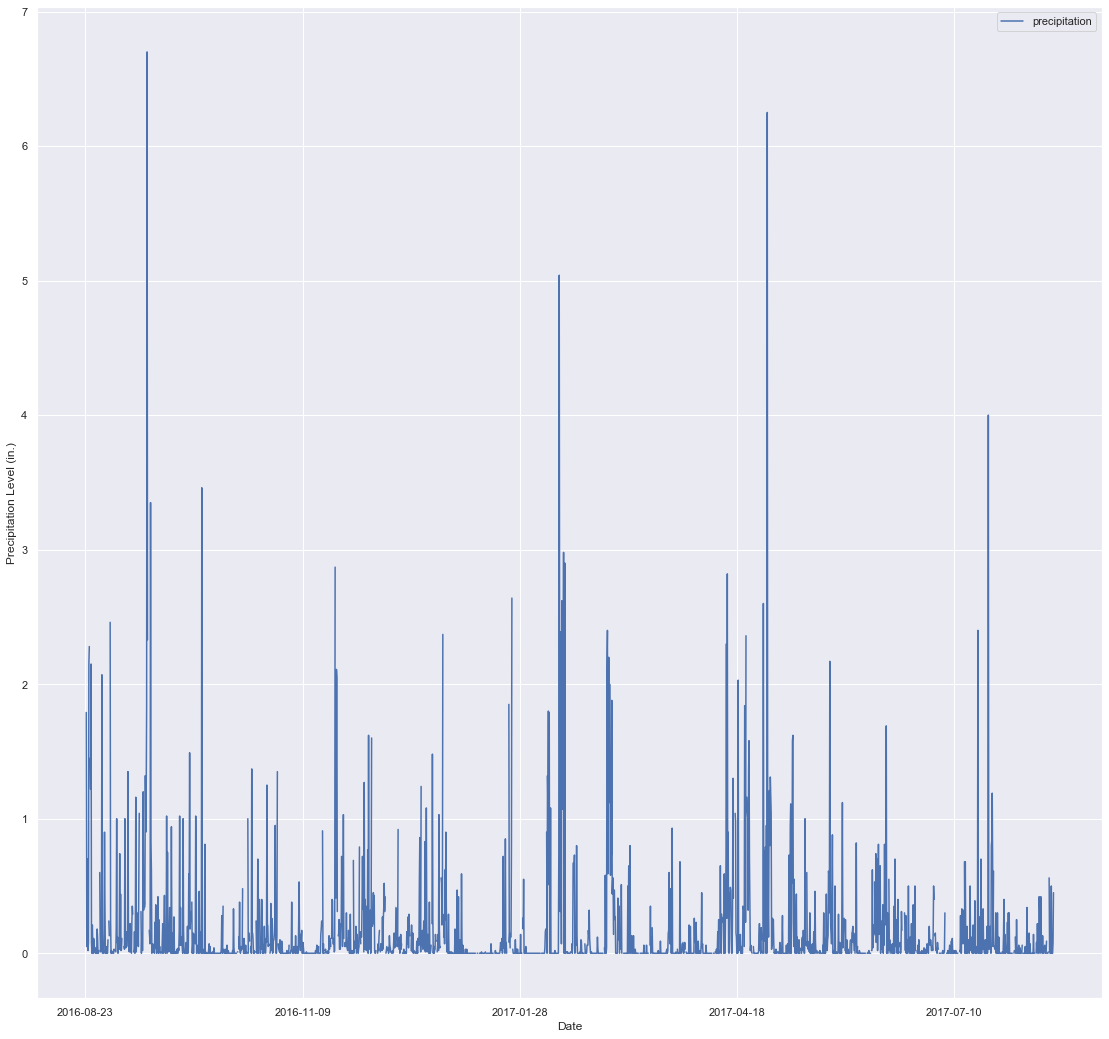

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data ** Also used Seaborn to make it large and aesthetic 
ax = prcp_df.plot();
ax.set_ylabel("Precipitation Level (in.)")
ax.set_xlabel("Date")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order.

  * Which station has the highest number of observations?

  * Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
count_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mas = count_by_station[0][0]
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == mas).all()

[(54.0, 85.0, 71.66378066378067)]

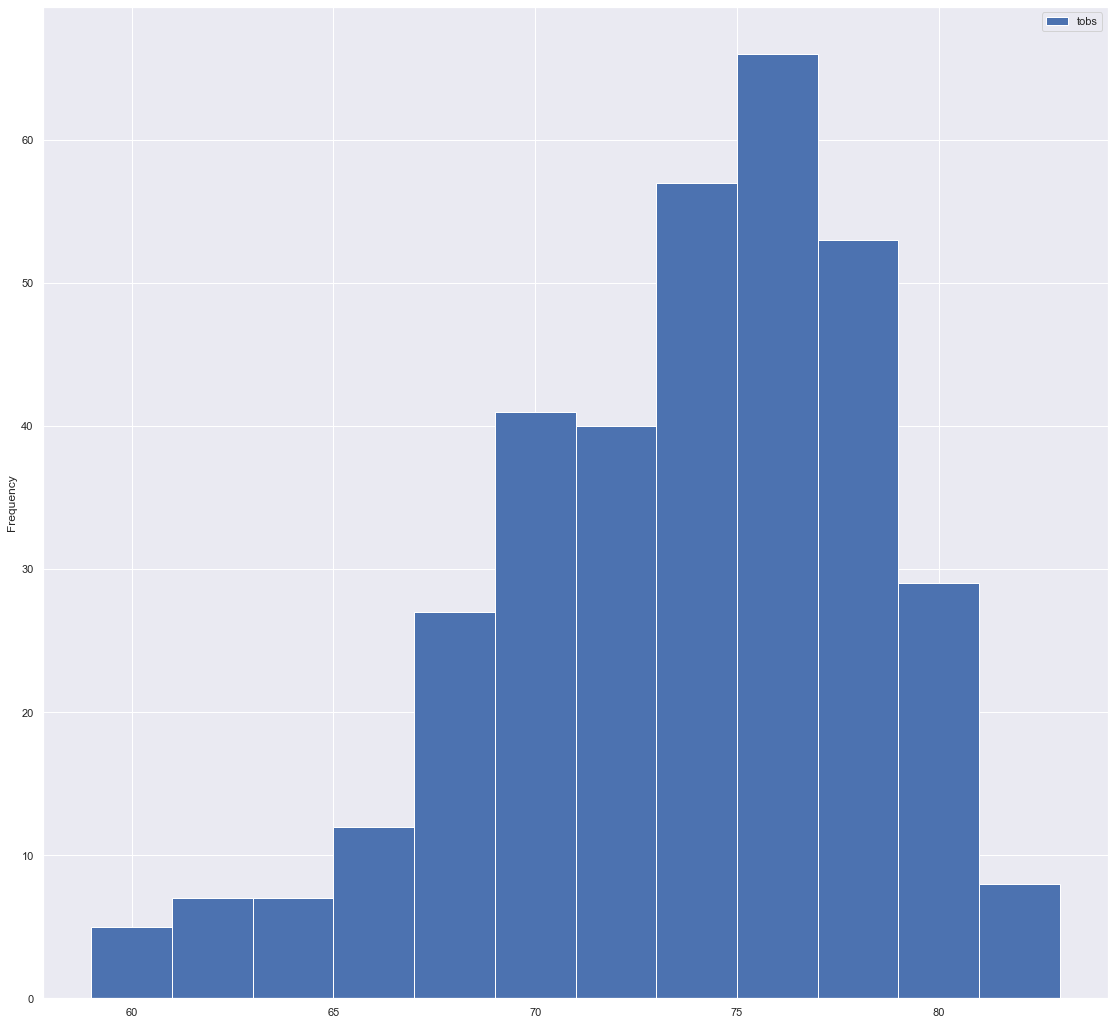

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = session.query(Measurement.tobs).filter(Measurement.station == mas).filter(Measurement.date >= last_year_date)
temp_df = pd.DataFrame(highest_temp, columns=['tobs'])
temp_df.plot.hist(bins=12);

# Optional Analysis??? 

There was code in the starter notenook that didn't align with the readme.md in the instructions. It was referenced in the Optional Analysis section so I am guessing it goes here.

The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

### Temperature Analysis II

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
triprefstart = '2017-03-01'
triprefend = '2017-03-14'
triprange = calc_temps(triprefstart, triprefend)
triprange

[(62.0, 71.03488372093024, 82.0)]

<BarContainer object of 1 artists>

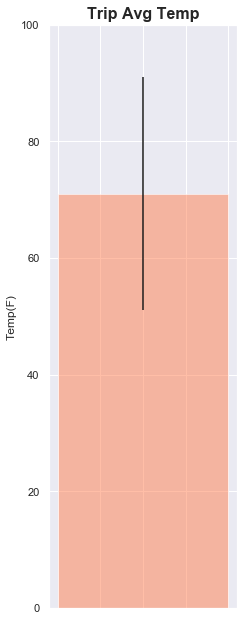

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error_prev_year = triprange[0][2]-triprange[0][0]
plt.figure(figsize=[3,10])
plt.ylim(0,100)
plt.ylabel("Temp(F)")
plt.title('Trip Avg Temp', fontsize=16, fontweight="bold")
plt.tick_params(axis='x',labelbottom=False)
plt.bar(1, triprange[0][1], yerr=error_prev_year, align='center', alpha=0.5,  color = "coral")

### Daily Rainfall Average

* Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_columns = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude,\
                 Station.elevation]
last_year_data = session.query(*query_columns).group_by(Measurement.station).\
                 join(Station, Measurement.station==Station.station).\
                 filter(Measurement.date >= triprefstart).filter(Measurement.date <= triprefend).\
                 order_by(func.sum(Measurement.prcp).desc()).all()
lyrf_df = pd.DataFrame(last_year_data,columns=["Station","Station_Name", "Total_Rainfall", "Latitude",\
            "Longitude", "Elevation"]).sort_values("Total_Rainfall",ascending=False)
lyrf_df

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00513117,"KANEOHE 838.1, HI US",5.76,21.42340,-157.80150,14.6
1,USC00519281,"WAIHEE 837.5, HI US",5.40,21.45167,-157.84889,32.9
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.50,21.33310,-157.80250,152.4
3,USC00517948,"PEARL CITY, HI US",3.04,21.39340,-157.97510,11.9
4,USC00519397,"WAIKIKI 717.2, HI US",2.74,21.27160,-157.81680,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.32,21.33556,-157.71139,19.5
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.75,21.52130,-157.83740,7.0
